# Biochemical Example - SERCA
In this example we demonstrate biochemical bond graph construction on a larger system. This tutorial highlights how the Julia modelling ecosystem helps build and solve reaction networks efficiently.

This tutorial has been adapted from https://github.com/mic-pan/BGT_BiochemicalNetworkTutorials/blob/master/4%20-%20Generating%20a%20model%20of%20SERCA.ipynb

In [ ]:
# Since BondGraphs is not yet in the package manager, we will need to include it directly from Github
# NOTE: You will need Julia >= 1.7
using Pkg; Pkg.add(url="https://github.com/jedforrest/BondGraphs.jl")
using BondGraphs

## SERCA Model
We will model the SERCA reaction network as described in Tran et al. (2009) and Pan et al. (2018).

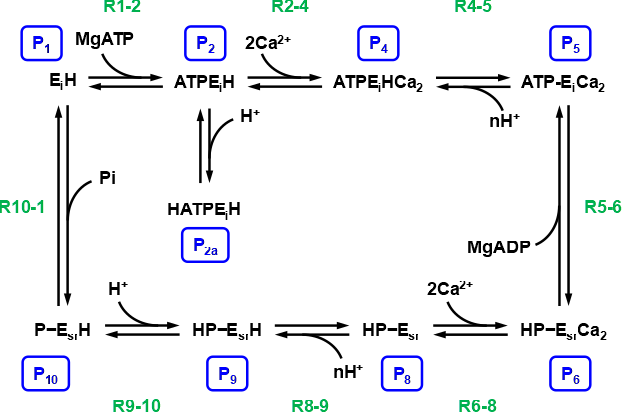

We can represent the above diagram as a reaction network using the existing modeling package `Catalyst.jl`

In [ ]:
using Catalyst
rn_serca = @reaction_network SERCA begin
    (1, 1), P1 + MgATP <--> P2
    (1, 1), P2 + H <--> P2a
    (1, 1), P2 + 2Cai <--> P4
    (1, 1), P4 <--> P5 + 2H
    (1, 1), P5 <--> P6 + MgADP
    (1, 1), P6 <--> P8 + 2Casr
    (1, 1), P8 + 2H <--> P9
    (1, 1), P9 <--> P10 + H
    (1, 1), P10 <--> P1 + Pi
end

`BondGraphs.jl` can convert a reaction network into a bond graph automatically

In [ ]:
chemostats = ["MgATP", "MgADP", "Pi", "H", "Cai", "Casr"] # chemical sources with constant concentration in the model
bg_serca = BondGraph(rn_serca; chemostats)

using Plots
plot(bg_serca, size=(600,600), fontsize=10)

The equations for the concentrations of the core species $P_i$ are automatically derived

In [ ]:
constitutive_relations(bg_serca)

Next we set the parameter values for the reaction rates $r$, the species affinities $K$, the chemostat concentrations $x_s$, and the initial concentrations for all $P_i$.

In this simulation, we have calcium concentration increasing over time with $[\ce{Ca^2+}] = 0.05 + 0.01t$

In [ ]:
# Define reaction rates, affinities, chemostats, and initial conditions
reaction_rates = [
    :R1 => 0.00053004, 
    :R2 => 8326784.0537,
    :R3 => 1567.7476,
    :R4 => 1567.7476,
    :R5 => 3063.4006,
    :R6 => 130852.3839,
    :R7 => 11612934.8748,
    :R8 => 11612934.8748,
    :R9 => 0.049926
]

species_affinities = [
    :P1 => 5263.6085,
    :P2 => 3803.6518,
    :P2a => 3110.4445,
    :P4 => 16520516.1239,
    :P5 => 0.82914,
    :P6 => 993148.433,
    :P8 => 37.7379,
    :P9 => 2230.2717,
    :P10 => 410.6048,
    :Cai => 1.9058,
    :Casr => 31.764,
    :MgATP => 244.3021,
    :MgADP => 5.8126e-7,
    :Pi => 0.014921,
    :H => 1862.5406
]

vol_sr = 2.28
chemostat_amounts = [
    :Cai => t -> 0.0057,
    :Casr => t -> vol_sr*(0.05 + 0.01t), # Ca2+ increases over time
    :H => t -> 0.004028,
    :MgADP => t -> 1.3794,
    :MgATP => t -> 3.8,
    :Pi => t -> 570
]

initial_conditions = [
    :P1 => 0.000483061870385487,
    :P2 => 0.0574915174273067,
    :P2a => 0.527445119834607,
    :P4 => 1.51818391164022e-09,
    :P5 => 0.000521923287622898,
    :P6 => 7.80721128535043e-05,
    :P8 => 0.156693953834181,
    :P9 => 0.149232225342376,
    :P10 => 0.108044124948978
]

for (reaction, rate) in reaction_rates
    getproperty(bg_serca, reaction).r = rate
end
for (species, affinity) in species_affinities
    getproperty(bg_serca, species).K = affinity
end
for (chemostat, amount) in chemostat_amounts
    getproperty(bg_serca, chemostat).xs = amount
end
for (species, ic) in initial_conditions
    getproperty(bg_serca, species).q = ic
end

Finally, we numerically solve our system of equations.

Note: because these equations are stiff, we are required to use a stiff solver such as Rosenbrock23.

In [ ]:
import DifferentialEquations: Rosenbrock23 # stiff solver

tspan = (0., 200.)
sol = simulate(bg_serca, tspan; solver=Rosenbrock23());

In [ ]:
plot(sol, lw=2, legend=:right)